Progetto Data Mining A.A. 2019/2020
=====

Asteroidi e comete: analisi del diametro, dell'orbita e della pericolosità
---

Francesco Pasceri matricola 204963

In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
from math import sqrt

from IPython.display import display, HTML
import dataframe_image as dfi

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate

from sklearn.linear_model import SGDRegressor, HuberRegressor, LinearRegression, Ridge, BayesianRidge 
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, VotingClassifier
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

print('imported')

imported


In [2]:
# size label grafici
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

Fase 3: Regressione del diametro
---

<b><u>
Studiare il diametro di un corpo celeste è molto importante per avere conoscenza in merito alla sua struttura, alla sua orbita e altre grandezze rilevanti (massa, volume, etc.).
    
Definiamo quindi delle strutture dati base e dei metodi che consentono di effettuare i calcoli.
</u></b>

In [3]:
df_clfs_tot = []
df_clfs = []

dt_clfs_tot = None
dt_clfs = None

<b><u>
Il metodo seguente <font color='red'>grid_searching</font> è uno dei più importanti in quanto consente di effettuare, in base al passaggio dei parametri </u></b>params<b><u>, una Grid Search dei valori più interessanti del regressore. Successivamente sfrutta il metodo </u></b>compute metrics<b><u> per effettuare i calcoli delle metriche prese in considerazione e inserirli nella struttura dati finale.
</u></b>

In [4]:
def grid_searching(model, name, X_train, X_test, y_train, y_test, k_feature, params=None):
    clf = {}
    
    # grid searching
    if params is not None:
        grid_searcher = GridSearchCV(estimator=model, cv=5, n_jobs=-1, param_grid=params, 
                                     scoring='neg_mean_squared_error')
        grid_searcher.fit(X_train, y_train)
        
        best_model = grid_searcher.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)
    
    #cross_validating
    scores = cross_validate(best_model, X_train, y_train, cv=5, return_train_score=True, 
                            scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'])

    #predicting
    y_prediction = best_model.predict(X_test)

    #choose dataframe
    df = df_clfs
    
    #saving
    if k_feature:
        model_name = 'Z_'+name
    else:
        model_name = name
        #df = df_clfs_tot
    
    #fill dict
    clf['1_Name']= model_name
    clf['2_Type'] = best_model
    compute_metrics(df, clf, scores, y_prediction, y_test)

    with open('Saved_files/'+model_name+'_clf','wb') as f:
        pickle.dump(best_model, f)

<b><u>
Tre sono le misure di valutazione dei regressori prese in esame:
    
    1. R2 score
    2. Mean Squared Error
    3. Mean Absolute Error
</u></b>

In [5]:
def compute_metrics(dataframe, clf, scores, y_prediction, y_tests):
    
    clf['3_R2_train'] = abs(np.mean(scores['train_r2']))
    clf['5_MAE_train'] = abs(np.mean(scores['train_neg_mean_absolute_error']))
    clf['7_MSE_train'] = abs(np.mean(scores['train_neg_mean_squared_error']))

    clf['4_R2_test'] = abs(r2_score(y_pred=y_prediction, y_true=y_test))
    clf['6_MAE_test'] = abs(mean_absolute_error(y_pred=y_prediction, y_true=y_test))
    clf['8_MSE_test'] = abs(mean_squared_error(y_pred=y_prediction, y_true=y_test))
    
    toAdd = True
    for i in range(len(dataframe)):
        if dataframe[i]['1_Name'] in clf['1_Name']:
            dataframe[i] = clf
            toAdd = False
            break
    if toAdd:
        dataframe.append(clf)

In [6]:
def plot_histograms(bar_1, bar_2, argument_str, dataframe, legend_list):
    fig, ax = plt.subplots(figsize=(20,8))
    width = 0.250
    i = np.arange(len(bar_1))
    train_bars = ax.bar(i, bar_1, width, label=legend_list[0])
    test_bars = ax.bar(i+width, bar_2, width, label=legend_list[1])

    ax.set_xlabel("Regressors",fontsize=20)

    ax.set_ylabel(argument_str + ' Value',fontsize=20)
    ax.set_title(argument_str + ' ' + legend_list[0] + ' VS ' + legend_list[1],fontsize=20)
    ax.set_xticklabels(dataframe['1_Name'], rotation = 90)
    ax.set_xticks(i + width / 2) 

    plt.legend()
    #ax.legend((train_bars,test_bars),legend_list,fontsize=20)
    plt.rc('font', size=BIGGER_SIZE)
    plt.show()

In [68]:
def plot(name,prediction, y_test):
    plt.title(name)
    plt.scatter(y_test,prediction, c='orange',label='predictions')
    plt.plot(y_test,y_test,c='blue',label='y=x')
    plt.xlabel('real')
    plt.ylabel('estimated')
    plt.legend()
    plt.rc('font', size=BIGGER_SIZE)
    plt.show()

def score(prediction, y_test):
    score = r2_score(prediction,y_test)
    return score

def announce(score):
    print('The R^2 score achieved using this regression is:', round(score,3))

## 1. Import data

<b><u>
Primo step è quello di recuperare il dataset post pre-processing e quindi buono alla risoluzione dei regressori.
</u></b>

In [8]:
with open('data','rb') as f:
    data = pickle.load(f)

data.head()

,neo,pha,H,diameter,albedo,e,a,q,i,om,...,class,condition_code,log(albedo),log(n),log(H),log(ad),log(e),log(om),log(i),log(q)
0,0,0,3.40,939.400,0.0900,0.076009,2.769165,2.558684,10.594067,80.305531,...,0,0,-2.407946,-1.542316,1.223775,1.091805,-2.576903,4.385838,2.360294,0.939493
1,0,0,4.20,545.000,0.1010,0.229972,2.773841,2.135935,34.832932,173.024741,...,0,0,-2.292635,-1.544847,1.435085,1.227225,-1.469797,5.153435,3.550563,0.758904
2,0,0,5.33,246.596,0.2140,0.256936,2.668285,1.982706,12.991043,169.851482,...,0,0,-1.541779,-1.486651,1.673351,1.210113,-1.358927,5.134924,2.564260,0.684462
3,0,0,3.00,525.400,0.4228,0.088721,2.361418,2.151909,7.141771,103.810804,...,0,0,-0.860856,-1.303390,1.098612,0.944266,-2.422253,4.642570,1.965961,0.766356
4,0,0,6.90,106.699,0.2740,0.190913,2.574037,2.082619,5.367427,141.571026,...,0,0,-1.294627,-1.432710,1.931521,1.120196,-1.655936,4.952802,1.680349,0.733626


In [9]:
data['diameter'].describe()

count    139014.000000
mean          5.468143
std           9.338024
min           0.008000
25%           2.765000
50%           3.954000
75%           5.742000
max         939.400000
Name: diameter, dtype: float64

## 2. Definizione di training set e test set

<b><u>
Recuperato il dataset andiamo a studiarlo. Con un semplice campionamento estraiamo dal dataset originale, ventimila (20000) record che costituiranno il nostro data set. Successivamente, estraiamo le etichette da questo.
</u></b>

In [70]:
data_1 = data[data['diameter']>=100]
data_1 = pd.concat([data_1, data[data['diameter']<100].sample(20000-data_1.shape[0])])

X = data_1.drop(['diameter'], axis=1)
Y = data_1['diameter']

X.head()

,neo,pha,H,albedo,e,a,q,i,om,w,...,class,condition_code,log(albedo),log(n),log(H),log(ad),log(e),log(om),log(i),log(q)
0,0,0,3.40,0.0900,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,...,0,0,-2.407946,-1.542316,1.223775,1.091805,-2.576903,4.385838,2.360294,0.939493
1,0,0,4.20,0.1010,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,...,0,0,-2.292635,-1.544847,1.435085,1.227225,-1.469797,5.153435,3.550563,0.758904
2,0,0,5.33,0.2140,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,...,0,0,-1.541779,-1.486651,1.673351,1.210113,-1.358927,5.134924,2.564260,0.684462
3,0,0,3.00,0.4228,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,...,0,0,-0.860856,-1.303390,1.098612,0.944266,-2.422253,4.642570,1.965961,0.766356
4,0,0,6.90,0.2740,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,...,0,0,-1.294627,-1.432710,1.931521,1.120196,-1.655936,4.952802,1.680349,0.733626


In [71]:
Y.describe()

count    20000.000000
mean         7.004001
std         20.085320
min          0.018000
25%          2.786000
50%          3.983000
75%          5.818000
max        939.400000
Name: diameter, dtype: float64

#### Normalizzazione e <i>splitting</i>

<b><u>
Per normalizzare i dati usiamo lo StandardScaler di scikit-learn. Sostanzialmente, lo scaler procede sottraendo la media e dividendo per la varianza.</u></b><br /><br />
    
- $z =\frac{x-mean}{variance}$

<b><u>Successivamente andremo a suddividere training set e test set con percentuale del 80% e 20%</u></b>

In [72]:
std_scaler = StandardScaler().fit(X)
std_X = std_scaler.fit_transform(X)

print(std_X.shape, Y.shape)

(20000, 27) (20000,)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(std_X, Y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16000, 27) (16000,)
(4000, 27) (4000,)


## 3. Model regression

##### 1. Linear models

In [14]:
estimator = LinearRegression()
grid_searching(k_feature=False, model=estimator, name='LinearReg', 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [15]:
params_ = {
    'alpha' : [1., 5., 10., 50., 100.],
    'loss' : ['squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}
estimator = SGDRegressor()
grid_searching(k_feature=False, model=estimator, name='SGDReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [16]:
estimator = HuberRegressor()
grid_searching(k_feature=False, model=estimator, name='HuberReg', 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [17]:
params_ = {
    'alpha' : [1., 5., 10., 50., 100.]
}
estimator = Ridge()
grid_searching(k_feature=False, model=estimator, name='RidgeReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [18]:
params_ = {
    'alpha_1' : [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 50., 100.]
}
estimator = BayesianRidge()
grid_searching(k_feature=False, model=estimator, name='BayesRidReg', params=params_,
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [19]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180


##### 2. Tree Models

In [20]:
params_ = {
    'splitter': ['best', 'random'],
    'criterion' : ['mse', 'friedman_mse', 'mae'],
}
estimator=DecisionTreeRegressor()
grid_searching(k_feature=False, model=estimator, name='DecisionTreeReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [21]:
params_ = {
    'splitter': ['best', 'random']
}
estimator=ExtraTreeRegressor()
grid_searching(k_feature=False, model=estimator, name='ExtraTreeReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [22]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180
5,DecisionTreeReg,DecisionTreeRegressor(splitter='random'),1.000000,0.000000,0.000000,0.966195,0.858882,10.903277
6,ExtraTreeReg,ExtraTreeRegressor(splitter='best'),1.000000,0.000000,0.000000,0.966221,0.835989,10.894782


##### 3. Nearest Neighbor Regressor

In [23]:
params_ = {
    'n_neighbors' : [5, 10, 15, 50]
}
estimator=KNeighborsRegressor()
grid_searching(k_feature=False, model=estimator, name='KNeighReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [24]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180
5,DecisionTreeReg,DecisionTreeRegressor(splitter='random'),1.000000,0.000000,0.000000,0.966195,0.858882,10.903277
6,ExtraTreeReg,ExtraTreeRegressor(splitter='best'),1.000000,0.000000,0.000000,0.966221,0.835989,10.894782
7,KNeighReg,KNeighborsRegressor(n_neighbors=10),0.818402,1.186264,77.804445,0.931748,1.201972,22.013429


##### 4. Ensemble Regressors

In [25]:
params_ = {
    'n_estimators' : [5, 10, 25, 50],
    'base_estimator' : [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=10),
                       DecisionTreeRegressor(max_depth=15), DecisionTreeRegressor(max_depth=25),
                       DecisionTreeRegressor(max_depth=30)]
}
estimator=AdaBoostRegressor()
grid_searching(k_feature=False, model=estimator, name='AdaBoostReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [26]:
params_ = {
    'n_estimators' : [5, 10, 25, 30],
    'loss' : ['ls','lad','quantile']
}
estimator=GradientBoostingRegressor()
grid_searching(k_feature=False, model=estimator, name='GradBoostReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [27]:
params_ = {
    'n_estimators' : [5, 10, 25, 50],
    'base_estimator' : [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=10),
                       DecisionTreeRegressor(max_depth=15), DecisionTreeRegressor(max_depth=25),
                       DecisionTreeRegressor(max_depth=30)]
}
estimator=BaggingRegressor()
grid_searching(k_feature=False, model=estimator, name='BaggingReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [28]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180
5,DecisionTreeReg,DecisionTreeRegressor(splitter='random'),1.000000,0.000000,0.000000,0.966195,0.858882,10.903277
6,ExtraTreeReg,ExtraTreeRegressor(splitter='best'),1.000000,0.000000,0.000000,0.966221,0.835989,10.894782
7,KNeighReg,KNeighborsRegressor(n_neighbors=10),0.818402,1.186264,77.804445,0.931748,1.201972,22.013429
8,AdaBoostReg,"(DecisionTreeRegressor(max_depth=10, random_st...",0.999343,0.368096,0.274394,0.971802,0.670174,9.094699
9,GradBoostReg,([DecisionTreeRegressor(criterion='friedman_ms...,0.977627,1.407690,9.407901,0.954864,1.476699,14.558001


##### 5. Support Vector Machine Regressors

In [29]:
model = SVR(kernel='poly', degree=2, gamma='auto')
grid_searching(k_feature=False, model=model, name='SVReg_poly',
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [30]:
params_ = {
    'kernel' : ['linear'],
    'gamma' : ['auto'],
    'C' : [0.1,1,10,50]
}
model = SVR()
grid_searching(k_feature=False, model=model, name='SVReg_lin', params=params_,
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [31]:
model = SVR(kernel='rbf', gamma='auto')
grid_searching(k_feature=False, model=model, name='SVReg_rbf', 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [32]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180
5,DecisionTreeReg,DecisionTreeRegressor(splitter='random'),1.000000,0.000000,0.000000,0.966195,0.858882,10.903277
6,ExtraTreeReg,ExtraTreeRegressor(splitter='best'),1.000000,0.000000,0.000000,0.966221,0.835989,10.894782
7,KNeighReg,KNeighborsRegressor(n_neighbors=10),0.818402,1.186264,77.804445,0.931748,1.201972,22.013429
8,AdaBoostReg,"(DecisionTreeRegressor(max_depth=10, random_st...",0.999343,0.368096,0.274394,0.971802,0.670174,9.094699
9,GradBoostReg,([DecisionTreeRegressor(criterion='friedman_ms...,0.977627,1.407690,9.407901,0.954864,1.476699,14.558001


##### 6. MLP Regressor

In [33]:
params_ = {
    'hidden_layer_sizes' : [(10, ), (50, ), (100, ),
                           (10, 10, ), (10, 50, ), (10, 100),
                           (50,10, ), (50,50, ), (50,100, ),
                           (100,10, ), (100,50, ), (100,100,)],
    'learning_rate' : ['adaptive']
}
estimator = MLPRegressor()
grid_searching(k_feature=False, model=estimator, name='MLPReg', params=params_,
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [34]:
for clf in df_clfs:
    est = clf['2_Type']
    if clf['4_R2_test'] >= 89:
        plot(clf['1_Name'], est.predict(X_test), y_test)

In [35]:
dt_clfs_tot = pd.DataFrame(df_clfs)
dt_clfs_tot

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,LinearReg,LinearRegression(),0.902336,2.406039,41.536846,0.897669,2.448179,33.005201
1,SGDReg,SGDRegressor(alpha=1.0),0.401619,4.662197,249.828173,0.555109,4.326731,143.492203
2,HuberReg,HuberRegressor(),0.792108,1.793199,88.503626,0.831022,1.835176,54.501159
3,RidgeReg,Ridge(),0.902318,2.396247,41.544320,0.897892,2.438514,32.933119
4,BayesRidReg,BayesianRidge(alpha_1=100.0),0.902336,2.404945,41.537008,0.897691,2.447111,32.998180
5,DecisionTreeReg,DecisionTreeRegressor(splitter='random'),1.000000,0.000000,0.000000,0.966195,0.858882,10.903277
6,ExtraTreeReg,ExtraTreeRegressor(splitter='best'),1.000000,0.000000,0.000000,0.966221,0.835989,10.894782
7,KNeighReg,KNeighborsRegressor(n_neighbors=10),0.818402,1.186264,77.804445,0.931748,1.201972,22.013429
8,AdaBoostReg,"(DecisionTreeRegressor(max_depth=10, random_st...",0.999343,0.368096,0.274394,0.971802,0.670174,9.094699
9,GradBoostReg,([DecisionTreeRegressor(criterion='friedman_ms...,0.977627,1.407690,9.407901,0.954864,1.476699,14.558001


##### Saving data

In [36]:
with open('Saved_files/A_dataframe_total','wb') as f:
    pickle.dump(dt_clfs_tot,f)

## 4. Valutazione tramite misure

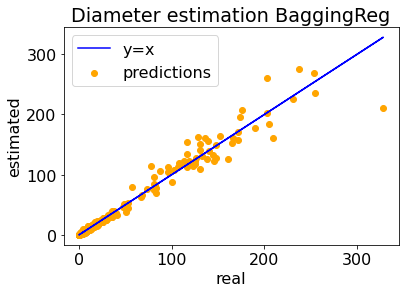

In [74]:
## Plotting behaviour of best classifier
best_estimator = dt_clfs_tot.iloc[dt_clfs_tot['4_R2_test'].idxmax()]
y_pred = best_estimator['2_Type'].predict(X_test)
plot('Diameter estimation '+best_estimator['1_Name'], y_pred, y_test)

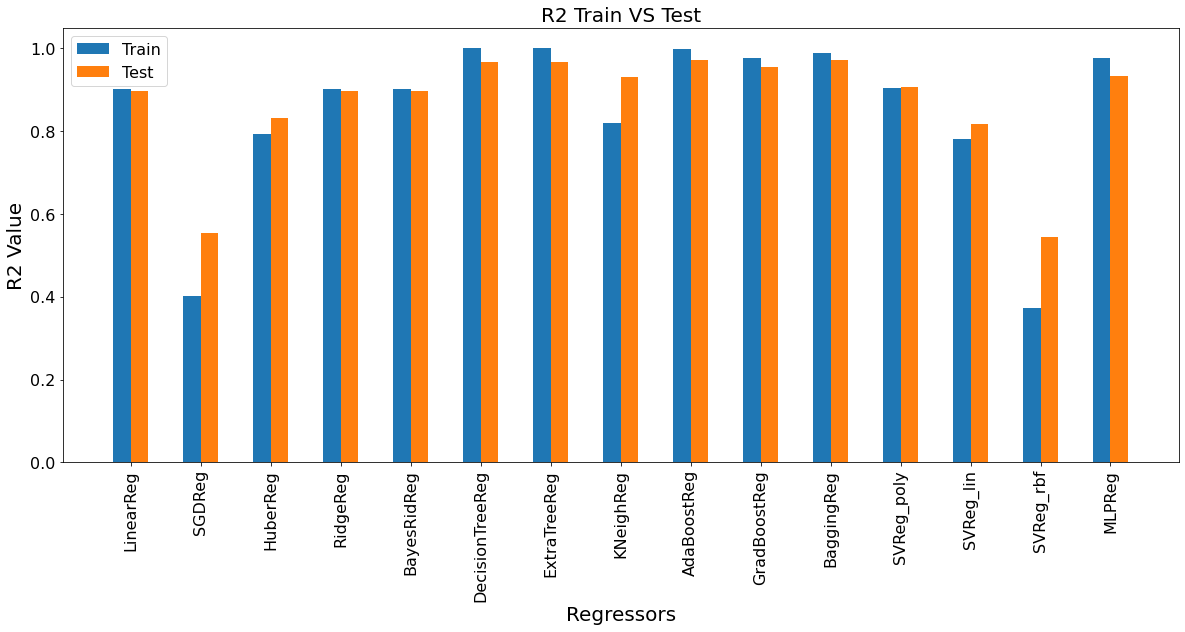

In [45]:
r2_train = dt_clfs_tot['3_R2_train'].values.tolist()
r2_test = dt_clfs_tot['4_R2_test'].values.tolist()

plot_histograms(r2_train, r2_test, 'R2', dt_clfs_tot, ['Train','Test'])

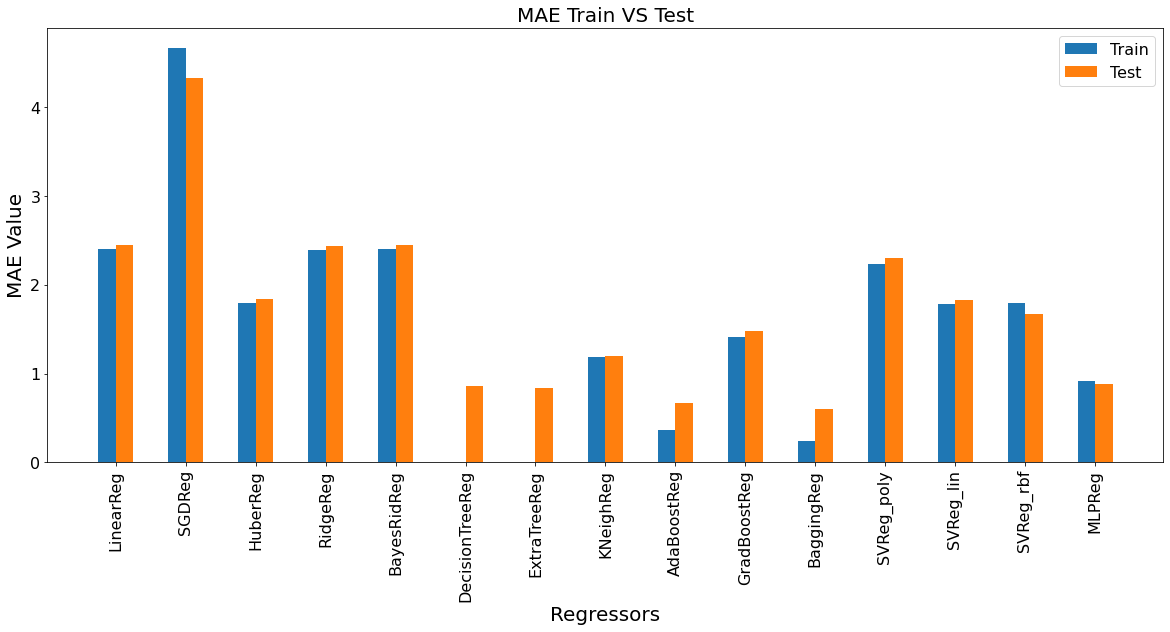

In [46]:
mae_train = dt_clfs_tot['5_MAE_train'].values.tolist()
mae_test = dt_clfs_tot['6_MAE_test'].values.tolist()

plot_histograms(mae_train, mae_test, 'MAE', dt_clfs_tot, ['Train','Test'])

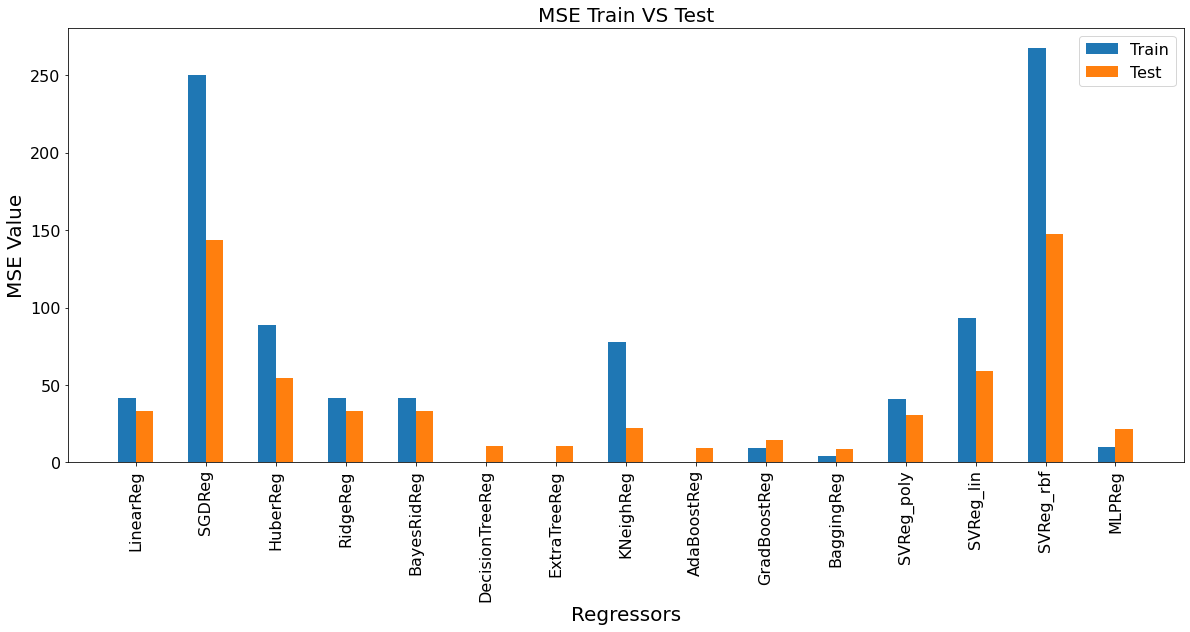

In [47]:
mse_train = dt_clfs_tot['7_MSE_train'].values.tolist()
mse_test = dt_clfs_tot['8_MSE_test'].values.tolist()

plot_histograms(mse_train, mse_test, 'MSE', dt_clfs_tot, ['Train','Test'])

## 5. Analysis top k features 

<b><u>
Dopo aver valutato il comportamento dei vari regressori, proviamo a capire se, estraendo mediante RandomForest i k attributi principali per la regressione riusciamo in qualche modo ad allegerire i modelli. Infine, confrontiamo i risultati per ottenere i risultati.
</u></b>

In [48]:
df_clfs = []
dt_clfs = None

##### Selecting top k features

In [49]:
from sklearn.ensemble import RandomForestRegressor

def sorted_importances(rows, labels):
    rnd_reg = RandomForestRegressor(n_estimators=40, n_jobs=3)
    rnd_reg.fit(rows, labels)
    attributes = rows.columns
    importances = rnd_reg.feature_importances_
    return (importances,attributes)

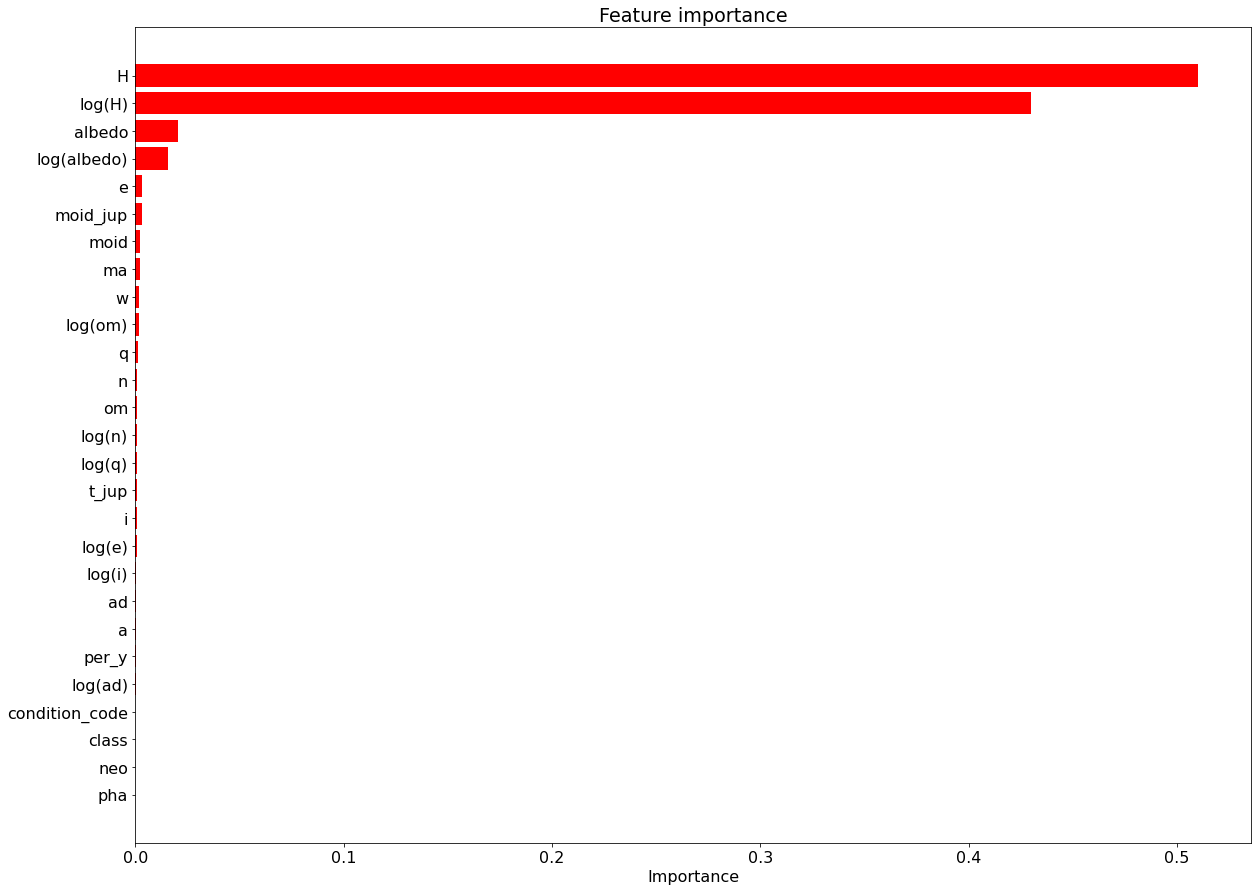

In [50]:
importances, attributes = sorted_importances(X, Y)
with open('Saved_files/utils_feature_classification','wb') as f: 
    pickle.dump(importances, f)

index = np.argsort(importances)
plt.figure(figsize=(20,15))
plt.rc('font', size=BIGGER_SIZE)
plt.title("Feature importance")
p = plt.barh(range(len(importances)), importances[index], color='r', align='center')
plt.yticks(range(len(importances)), attributes[index])
plt.xlabel("Importance")
plt.show()

In [51]:
k = 5
attr= index[-k:]

In [52]:
X=X.iloc[:,attr]
X.head()

,e,log(albedo),albedo,log(H),H
0,0.076009,-2.407946,0.0900,1.223775,3.40
1,0.229972,-2.292635,0.1010,1.435085,4.20
2,0.256936,-1.541779,0.2140,1.673351,5.33
3,0.088721,-0.860856,0.4228,1.098612,3.00
4,0.190913,-1.294627,0.2740,1.931521,6.90


#### Normalization and splitting

In [53]:
std_scaler = StandardScaler().fit(X)
std_X = std_scaler.fit_transform(X)

print(std_X.shape, Y.shape)

(20000, 5) (20000,)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(std_X, Y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16000, 5) (16000,)
(4000, 5) (4000,)


##### Training e test dei regressori 

In [55]:
# fitting
model = LinearRegression()
grid_searching(k_feature=True, model=model, name='LinearReg', 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [56]:
params_ = {
    'alpha' : [1., 5., 10., 50., 100.],
    'loss' : ['squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}
estimator = SGDRegressor()
grid_searching(k_feature=True, model=estimator, name='SGDReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [57]:
params_ = {
    'alpha' : [1., 5., 10., 50., 100.]
}
estimator = Ridge()
grid_searching(k_feature=True, model=estimator, name='RidgeReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [58]:
params_ = {
    'alpha_1' : [0.0001, 0.001, 0.01, 0.1, 1., 5., 10., 50., 100.]
}
estimator = BayesianRidge()
grid_searching(k_feature=True, model=estimator, name='BayesRidReg', params=params_,
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [59]:
params_ = {
    'n_estimators' : [5, 10, 25, 50],
    'base_estimator' : [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=10),
                       DecisionTreeRegressor(max_depth=15), DecisionTreeRegressor(max_depth=25),
                       DecisionTreeRegressor(max_depth=30)]
}

estimator=AdaBoostRegressor()
grid_searching(k_feature=True, model=estimator, name='AdaBoostReg', params=params_, 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [60]:
model = SVR(kernel='rbf', gamma='auto')
grid_searching(k_feature=True, model=model, name='SVR_rbf', 
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [61]:
params_ = {
    'hidden_layer_sizes' : [(10, ), (50, ), (100, ),
                           (10, 10, ), (10, 50, ), (10, 100),
                           (50,10, ), (50,50, ), (50,100, ),
                           (100,10, ), (100,50, ), (100,100,)],
    'learning_rate' : ['adaptive']
}
estimator = MLPRegressor()
grid_searching(k_feature=True, model=estimator, name='MLPReg', params=params_,
               X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)

In [62]:
dt_clfs = pd.DataFrame(df_clfs)
dt_clfs

,1_Name,2_Type,3_R2_train,5_MAE_train,7_MSE_train,4_R2_test,6_MAE_test,8_MSE_test
0,Z_LinearReg,LinearRegression(),0.870591,2.583911,55.118335,0.879870,2.567621,38.746050
1,Z_SGDReg,"SGDRegressor(alpha=1.0, loss='squared_epsilon_...",0.446913,4.584533,234.495569,0.512626,8.435454,157.194313
2,Z_RidgeReg,Ridge(),0.870579,2.573804,55.123077,0.880262,2.558601,38.619575
3,Z_BayesRidReg,BayesianRidge(alpha_1=100.0),0.870591,2.583659,55.118338,0.879879,2.567398,38.742902
4,Z_AdaBoostReg,"(DecisionTreeRegressor(max_depth=25, random_st...",0.999959,0.046700,0.017102,0.964424,0.748030,11.474475
5,Z_SVR_rbf,SVR(gamma='auto'),0.481303,1.396647,222.264405,0.736679,1.237894,84.929728
6,Z_MLPReg,"MLPRegressor(hidden_layer_sizes=(100, 50), lea...",0.992466,0.647346,3.134505,0.981711,0.719917,5.898696


##### Saving data

In [63]:
with open('Saved_files/A_dataframe_k_features','wb') as f:
    pickle.dump(dt_clfs,f)

## 6. Confronto tra "all features" e "top k features"

In [64]:
#1,2,3,4,5,8,1
row_1 = dt_clfs_tot.iloc[0:5]
row_2 = pd.DataFrame( dt_clfs_tot.iloc[8] ).T
row_3 = pd.DataFrame( dt_clfs_tot.iloc[11] ).T

orig_rows = pd.concat([row_1, row_3, row_2])

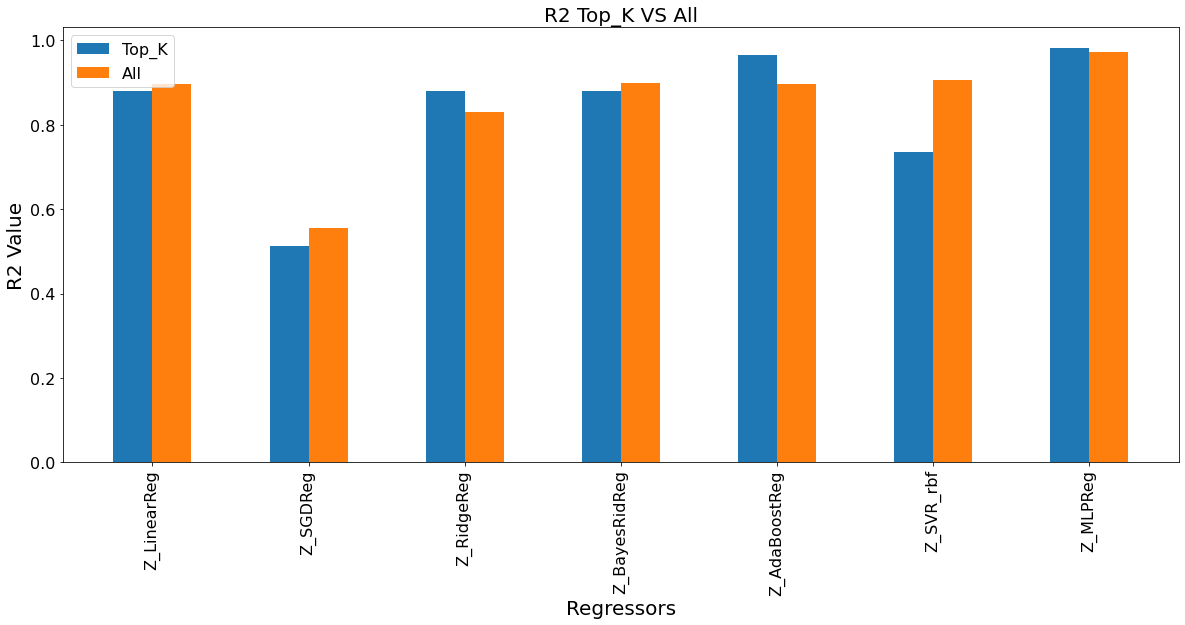

In [65]:
z_test = dt_clfs['4_R2_test'].values.tolist()
org_test = orig_rows['4_R2_test'].values.tolist()

plot_histograms(argument_str='R2', bar_1=z_test, bar_2=org_test, dataframe=dt_clfs, legend_list=['Top_K','All'])

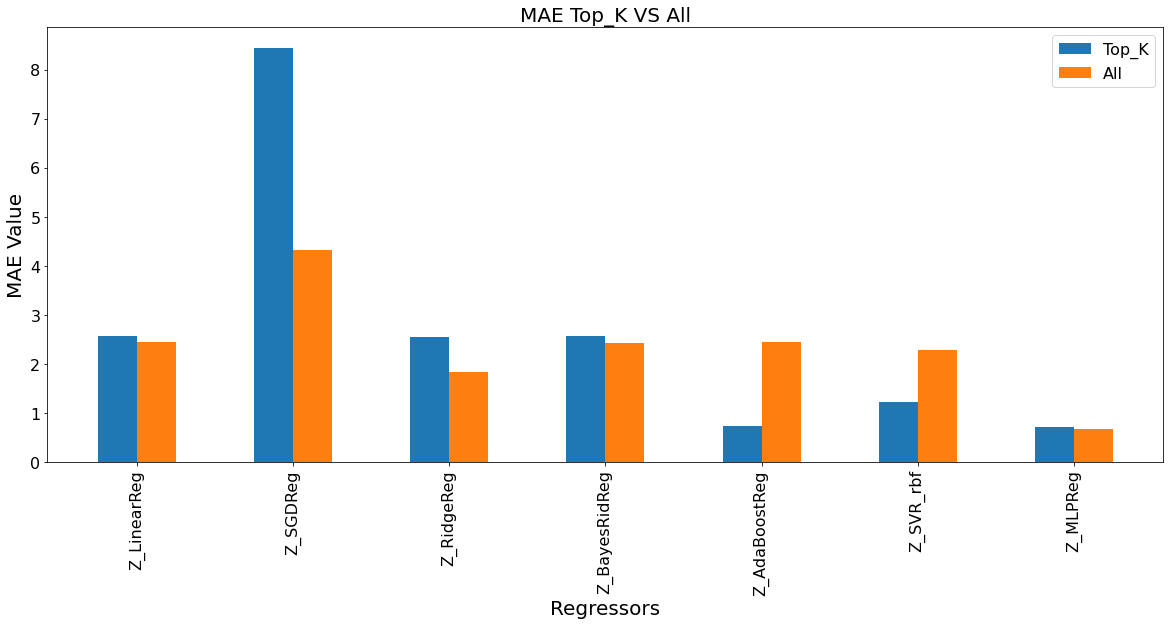

In [66]:
z_test = dt_clfs['6_MAE_test'].values.tolist()
org_test = orig_rows['6_MAE_test'].values.tolist()

plot_histograms(argument_str='MAE', bar_1=z_test, bar_2=org_test, dataframe=dt_clfs, legend_list=['Top_K','All'])

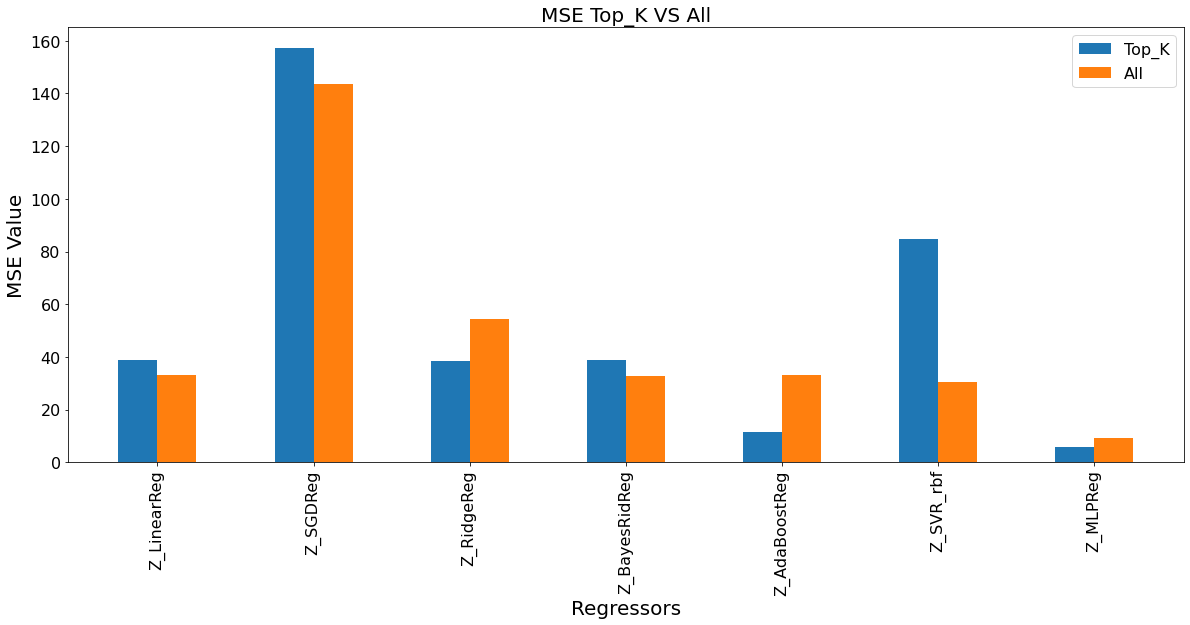

In [67]:
z_test = dt_clfs['8_MSE_test'].values.tolist()
org_test = orig_rows['8_MSE_test'].values.tolist()

plot_histograms(argument_str='MSE', bar_1=z_test, bar_2=org_test, dataframe=dt_clfs, legend_list=['Top_K','All'])